# KAN for Time Series Forecasting Demo

## 1. Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from kan import KAN
from models.model_helper import activation_helper
from tqdm import tqdm

torch.set_default_dtype(torch.float64)

## 2. Hyperparameters

In [76]:
lag = 1  # number of lags
T = 1001  # number of time points
num_series = 2  # number of time series

batch_size = 32
epochs = 20
lr = 1e-3

dim_input = num_series * lag
dim_output = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. Generate Data

In [77]:
# Simulate data with causal relationships
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.6)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

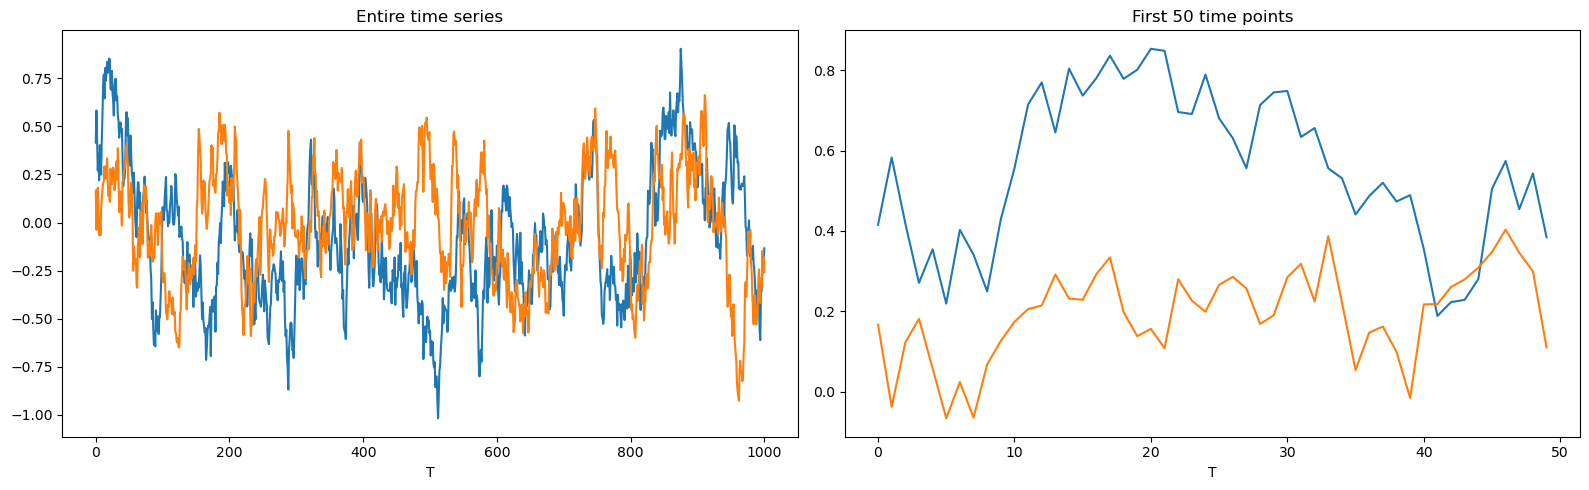

In [78]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

Plot the granger causality among time series

[[1 0]
 [0 1]]


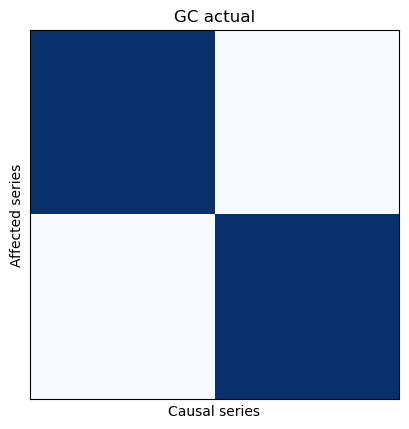

In [79]:
print(GC)

plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

## 4. Prepare the Data

- In this section, we choose TS1 as the target time series.

- The lags of the rest 4 series and TS1 itself will be used to predict the current value of TS1.

- For TS1, it is affected by TS0, TS1, TS3.

In [80]:
target_series = 0  # the series we want to predict

In [81]:
def pd_data(X):
    '''
    Use dataframe to show the data structure
    Y: target series
    ts{}_lag{}: value of time series {} with lag {}
    '''
    Y = X[:, :, target_series]
    df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]
    for i in range(num_series):
        for j in range(lag):
            df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]
    return df

def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32)

    return array

In [82]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, target_series][0, :T-lag].reshape(1, T-lag).T
print(Y.shape)

# Show the data structure using dataframe
# pd_data(X)

# change the data type from float to double
array = array.double()
Y = Y.double()

torch.Size([1000, 2])
torch.Size([1000, 1])


In [83]:
dataset = {}
dataset['train_input'] = array.to(device)
dataset['test_input'] = array.to(device)
dataset['train_label'] = Y.to(device)
dataset['test_label'] = Y.to(device)

## 5. KAN demo for Prediction

checkpoint directory created: ./model
saving model version 0.0


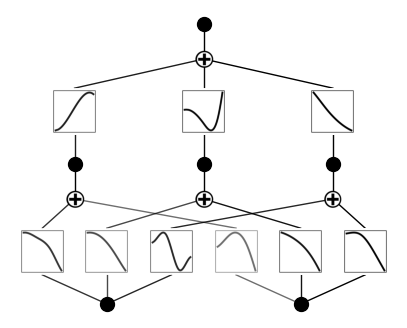

In [84]:
model = KAN(width=[dim_input, 3, dim_output], grid=3, k=3, seed=42)
model(array);
model.plot()

| train_loss: 8.38e-03 | test_loss: 8.38e-03 | reg: 4.30e+00 | : 100%|█| 20/20 [00:03<00:00,  5.00it


saving model version 0.1


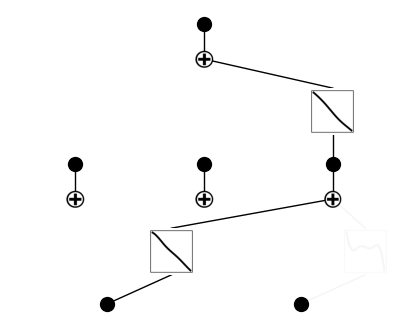

In [85]:
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
model.plot()

saving model version 0.2


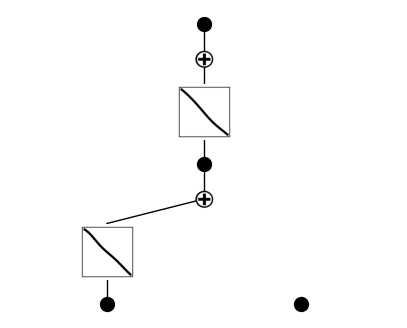

In [86]:
model = model.prune()
model.plot()

This result is exciting as it shows how each time series can affect the target series. 

Here TS1 will affect itself with lag=1, and this plot clearly shows this effect. Even though this demo setting is a quite simple and naive one, we can still hope that KAN can idealy work on this situation and by using pruning skill, it can find the granger causal relationships.

## 6. Show the KAN output for predicting

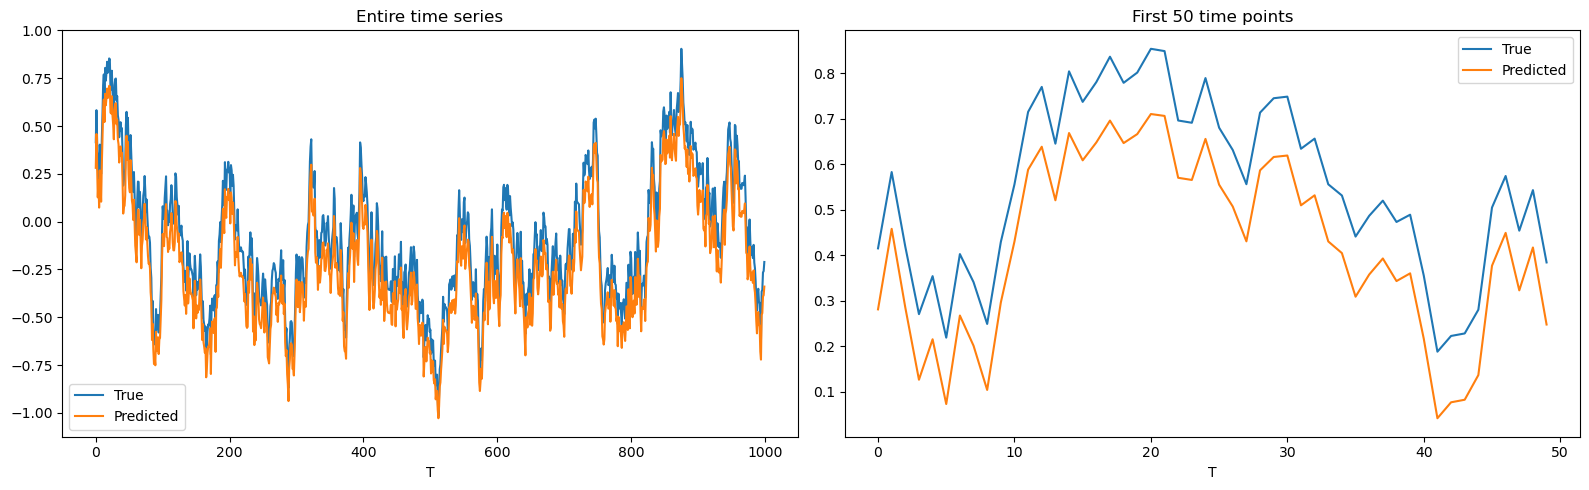

In [87]:
output = model(dataset['test_input'])

# plot output
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(dataset['test_label'].detach().numpy(), label='True')
axarr[0].plot(output.detach().numpy(), label='Predicted')
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[0].legend()
axarr[1].plot(dataset['test_label'].detach().numpy()[:50], label='True')
axarr[1].plot(output.detach().numpy()[:50], label='Predicted')
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
axarr[1].legend()
plt.tight_layout()
plt.show()